<a href="https://colab.research.google.com/github/DoubleCyclone/Neural-Network-From-Scratch/blob/main/notebooks/Neural_Network_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introduction & Setup
As a Machine Learning student (self-proclaimed), I am learning how to build and use various models. In this notebook specifically, I will create my own Neural Network from Scratch with Numpy.

I will be using the [**MNIST**](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset to train the model and run predictions.

Let's import the packages first.

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

At first I have to load the MNIST dataset. I will do this with pytorch as it does not really have anything to do with model building right now so it is not cheating!

In [39]:
# Load the MNIST dataset with the specified transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a DataLoader to load the dataset in batches
loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=False)
loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

After loading our train and test Datasets and the DataLoaders, I want to check how much data they contain.

In [40]:
print(f"Train data shape : {loader_train.dataset.data.shape}")
print(f"Train labels shape : {loader_train.dataset.targets.shape}")
print(f"Test data shape : {loader_test.dataset.data.shape}")
print(f"Test labels shape : {loader_test.dataset.targets.shape}")

Train data shape : torch.Size([60000, 28, 28])
Train labels shape : torch.Size([60000])
Test data shape : torch.Size([10000, 28, 28])
Test labels shape : torch.Size([10000])


Now let's plot a few of the data with their labels as visualization is of utmost importance especially when learning.

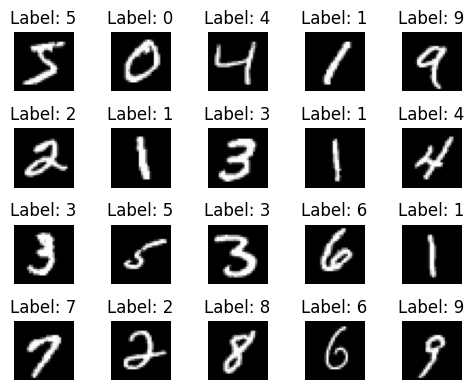

In [20]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(5, 4))

# Flatten to iterate easily
axs = axs.flatten()

# Print the first few images in a row
for i, (image, label) in enumerate(loader_train):
    # Print the first 20 samples
    if i < 20:
        axs[i].imshow(image[0].squeeze(), cmap='gray') # Show the image
        axs[i].set_title(f"Label: {label.item()}") # Set the label as the title
        axs[i].axis('off') # Turn off axis to make the image cleaner
    else:
        break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()